<!--NAVIGATION-->
< [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) | [Contents](Index.ipynb) | [Application: A Face Detection Pipeline](05.14-Image-Features.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Kernel Density Estimation

# 深入：核密度估计

> In the previous section we covered Gaussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator.
Recall that a density estimator is an algorithm which takes a $D$-dimensional dataset and produces an estimate of the $D$-dimensional probability distribution which that data is drawn from.
The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions.
*Kernel density estimation* (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component *per point*, resulting in an essentially non-parametric estimator of density.
In this section, we will explore the motivation and uses of KDE.

在上一节中我们介绍了高斯混合模型（GMM），它是一种介于聚类评估器和密度评估器的混合模型。回忆一下密度评估器的定义，这是一种从$D$维数据集中产生一个$D$为概率分布的算法。GMM算法使用了加权高斯分布和的方式实现了密度评估器。*核密度估计*在某种程度上是一个将高斯混合理念发展到其逻辑层次的算法：该算法是包含了每个数据点形成的一个高斯成分，得到一个基本上无参数的密度评估器。在本节中，我们会讨论和密度分析KDE的原理和应用。

> We begin with the standard imports:

导入包：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

## 初探KDE：直方图

> As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset.
For one dimensional data, you are probably already familiar with one simple density estimator: the histogram.
A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

前面已经讨论过，密度评估器是一种找到样本概率分布的模型，用以生成数据集的算法。对于一维数据而言，你应该已经熟悉其中一种简单的密度评估器：直方图。直方图将数据分成离散的桶，计算每个通中数据点的数量，然后将结果可视化成一张非常直观的图表。

> For example, let's create some data that is drawn from two normal distributions:

例如下面我们构建一些数据形成两个正态分布：

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

> We have previously seen that the standard count-based histogram can be created with the ``plt.hist()`` function.
By specifying the ``normed`` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

前面我们已经看到标准的直方图可以使用`plt.hist()`函数绘制。通过设置`density`参数，我们可以将直方图标准化，这时图像的高度不再代表数据点的数量，而是概率密度：

译者注：新版Matplotlib已经不再使用normed参数，原文和代码中的参数名称已经修改为density。

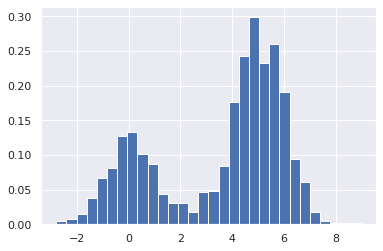

In [3]:
hist = plt.hist(x, bins=30, density=True)

> Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts.
This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

注意对上图来说，标准化只是修改了y轴的度量，但是每个桶相对高度与使用计数构建的直方图是一致的。标准化能够使得直方图的全部面积加起来等于1，因此我们可以通过直方图函数的输出结果来进行验证：

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

> One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.
For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!
Consider this example:

使用直方图作为密度评估器的一个问题是桶大小和位置的选择会导致展现出不同的数据特征。例如我们仅仅使用20个数据点的情况下，如何划分桶的选择会得到完全不同的数据解释。如下例：

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

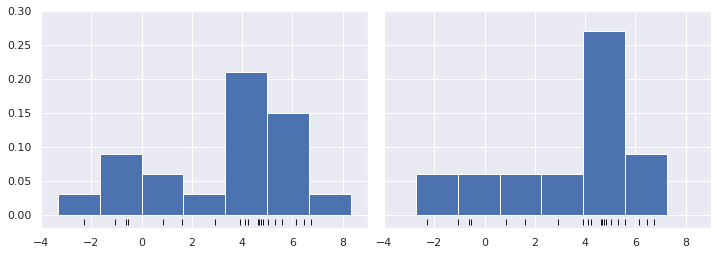

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

> On the left, the histogram makes clear that this is a bimodal distribution.
On the right, we see a unimodal distribution with a long tail.
Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data: with that in mind, how can you trust the intuition that histograms confer?
And how might we improve on this?

左边的直方图很明显是一个双峰分布。右边的直方图却是一个单峰缝补。如果不是看到了前面的代码，我们可能会猜测这两个直方图是从不同的数据集获得的：在这种情况下，我们如何能信任直方图给我们关于数据分布的直觉呢？我们该如何改进这点呢？

> Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.
Let's view this directly:

回头看一下，我们可以将直方图想象成方块组成的堆，我们可以将数据集中的每个数据点都堆一块放置到其从属的桶的最上方。我们来看看：

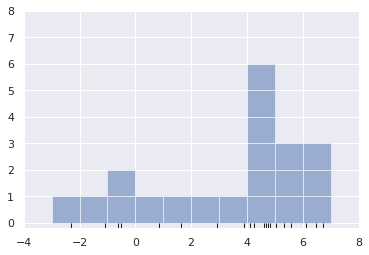

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8);

> The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points.
This mis-alignment between points and their blocks is a potential cause of the poor histogram results seen here.
But what if, instead of stacking the blocks aligned with the *bins*, we were to stack the blocks aligned with the *points they represent*?
If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result.
Let's try this:

刚才看到那两个直方图的问题实质在于，方块组成的堆高度通常反映的不是实际的附近数据点密度，而是取决于桶与数据点对齐的选择方式，这具有一定的偶然性。不合适的选择就是我们前面看到不正确的直方图结果的原因。但是如果我们不是将方块叠放到桶上，而是将方块叠放到它们*所代表的数据点*上会怎么样？这样做的话，这些方块不会对齐，我们可以将每个数据点在x轴的每个位置上的贡献叠加起来得到结果。例如：

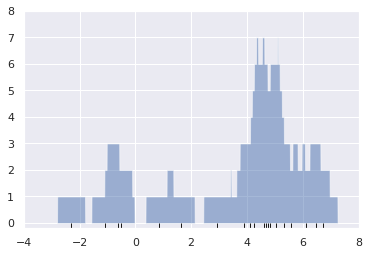

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

> The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram.
Still, the rough edges are not aesthetically pleasing, nor are they reflective of any true properties of the data.
In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian.
Let's use a standard normal curve at each point instead of a block:

结果看起来有点乱，但是它能比标准直方图更加鲁棒地反映数据的特征。然而图中的坚硬边界很不美观，且它们也无法反映数据的真实属性。我们可以考虑使用光滑的函数，比方说高斯函数，来平滑这个图形。下面我们在每个电商使用使用标准正态曲线来取代叠放的方块：

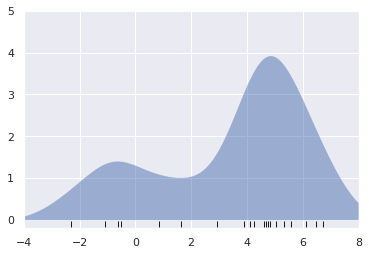

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

> This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one which has much less variance (i.e., changes much less in response to differences in sampling).

平滑后的图像，在每个输入点上都是高斯分布，能够提供对于数据分布的更加精确的形状，而且具有更少的差异（例如取样不同产生的差异小了许多）。

> These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel.
We'll now look at kernel density estimation in more detail.

后面这两张图就是核密度估计在一维数据上的例子：第一幅图使用的是“高帽”核，第二幅图使用的是高斯核。下面我们详细讨论核密度估计。

## Kernel Density Estimation in Practice

## 实践中使用核密度估计

> The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for a kernel density estimation: in particular, the Scikit-Learn KDE implementation supports one of six kernels, which you can read about in Scikit-Learn's [Density Estimation documentation](http://scikit-learn.org/stable/modules/density.html).

核密度估计中的自由参数是*核*，它设定了分布在每个点的形状以及控制着每个点上核大小的*核带宽*。实践中有许多可用的核密度估计：具体来说，Scikit-Learn的KDE实现了其中的6种，读者可以在Scikit-Learn在线文档[密度估计](http://scikit-learn.org/stable/modules/density.html)中查看。

> While there are several versions of kernel density estimation implemented in Python (notably in the SciPy and StatsModels packages), I prefer to use Scikit-Learn's version because of its efficiency and flexibility.
It is implemented in the ``sklearn.neighbors.KernelDensity`` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the ``atol`` (absolute tolerance) and ``rtol`` (relative tolerance) parameters.
The kernel bandwidth, which is a free parameter, can be determined using Scikit-Learn's standard cross validation tools as we will soon see.

虽然Python当中有一些核密度估计的实现（主要是在SciPy和StatsModels包中），作者还是建议使用Scikit-Learn的版本，因为它的高效和灵活性。这些评估器被实现在`sklearn.neighbors.KernelDensity`当中，它们能使用6种核类型以及数十种距离度量计算方法在多维数据中实现KDE。因为KDE方法较为计算密集，Scikit-Learn的评估器在底层使用了树形算法，并且能够使用`atol`（绝对容差）和`rtol`（相对容差）来平衡计算时间与精确度。自由参数核带宽可以使用标准的交叉验证工具决定，我们马上就会看到。

> Let's first show a simple example of replicating the above plot using the Scikit-Learn ``KernelDensity`` estimator:

下面使用Scikit-Learn的`KernelDensity`评估器重复一下上面的图表，作为一个简单的例子：

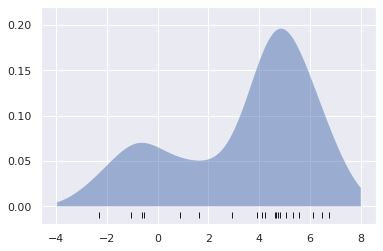

In [10]:
from sklearn.neighbors import KernelDensity

# 初始化KDE模型，拟合数据
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples返回概率密度的对数值
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);

> The result here is normalized such that the area under the curve is equal to 1.

上面的结果已经标准化了，因此曲线下方的面积和为1。

### Selecting the bandwidth via cross-validation

### 通过交叉验证选择带宽

> The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias–variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) where the structure in the data is washed out by the wide kernel.

KDE中带宽的选择对于寻找合适的密度估计是至关重要的，同时也是控制偏差的开关，这是密度估计方差的权衡值：太窄的带宽会导致高方差估计（也就是过拟合），可以认为一个数据点的存在或缺失会导致巨大的差异。太宽泛的带宽会导致高偏差估计（也就是欠拟合），整个数据的结构被过宽的核给抹平了。

> There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

在统计学中，基于数据相当严格的假设来估计最佳带宽有着很长的历史：如果你查看SciPy和StatsModels包中的KDE实现，你可以看到其中一些规则的实现。

> In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach.
With this in mind, the ``KernelDensity`` estimator in Scikit-Learn is designed such that it can be used directly within the Scikit-Learn's standard grid search tools.
Here we will use ``GridSearchCV`` to optimize the bandwidth for the preceding dataset.
Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

在机器学习领域，我们已经知道这样的超参数调整通常可以通过交叉验证方法来实现。因此Scikit-Learn中的`KernelDensity`评估器被设计成可以直接使用Scikit-Learn的标准网格搜索工具。这里我们将使用`GridSearchCV`来对前面的数据集的带宽进行优化。因为这是一个非常小的数据集，我们会使用留出一个的交叉验证方法，这能在每次交叉验证测试中尽量保证训练集的最大样本量：

译者注：新版Scikit-Learn已经将GridSearchCV和LeaveOneOut移到了`sklearn.model_selection`包中，并且LeaveOneOut不再需要提供参数。下面的代码做了相应修改。

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

> Now we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood):

现在我们就可以得到最大分值的带宽了（在这个例子中默认是分值的对数）：

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

> The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0 (i.e., the default width of ``scipy.stats.norm``).

带宽的最优值正好非常接近我们在前面例子中使用的1.0（也就是`scipy.stats.norm`的默认宽度）。

## Example: KDE on a Sphere

## 例子：球面上的KDE

> Perhaps the most common use of KDE is in graphically representing distributions of points.
For example, in the Seaborn visualization library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)), KDE is built in and automatically used to help visualize points in one and two dimensions.

也许KDE最常见的应用就是数据点分布的图像表示。例如在Seaborn可视化库（参见[使用Seaborn可视化](04.14-Visualization-With-Seaborn.ipynb)）中，KDE是在一维和二维空间中的內建自动化可视化方法。

> Here we will look at a slightly more sophisticated use of KDE for visualization of distributions.
We will make use of some geographic data that can be loaded with Scikit-Learn: the geographic distributions of recorded observations of two South American mammals, *Bradypus variegatus* (the Brown-throated Sloth) and *Microryzomys minutus* (the Forest Small Rice Rat).

这里我们将要讨论一个稍微复杂一些的KDE进行数据分布可视化的例子：观察记录到两种南美哺乳动物的地理分布情况，棕喉树懒和森林小稻鼠。

> With Scikit-Learn, we can fetch this data as follows:

使用Scikit-Learn如下获取数据：

In [13]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# 提取物种ID和位置数据
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

> With this data loaded, we can use the Basemap toolkit (mentioned previously in [Geographic Data with Basemap](04.13-Geographic-Data-With-Basemap.ipynb)) to plot the observed locations of these two species on the map of South America.

当数据载入后，我们可以使用Basemap工具集（之前在[使用Basemap创建地理位置图表](04.13-Geographic-Data-With-Basemap.ipynb)中介绍过）来绘制这两个物种在南美洲地图上观测的位置。

译者注：译者所用Matplotlib 3.1版本有个bug，basemap中__init__方法会抛出警告，master分支已经修复，但未并入发行版，此处保留了该警告，但不影响后续功能

/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


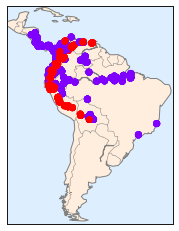

In [14]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# 使用basemap绘制海岸线
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# 绘制位置
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

> Unfortunately, this doesn't give a very good idea of the density of the species, because points in the species range may overlap one another.
You may not realize it by looking at this plot, but there are over 1,600 points shown here!

不过，上图并没有给出这两种动物的分布密度估计，因为这些点的范围互相重叠了。观察上图可以看到很多分布点，但是实际上有超过1600个数据点绘制在图中。

> Let's use kernel density estimation to show this distribution in a more interpretable way: as a smooth indication of density on the map.
Because the coordinate system here lies on a spherical surface rather than a flat plane, we will use the ``haversine`` distance metric, which will correctly represent distances on a curved surface.

让我们使用核密度估计将这个分布展示成更加有含义的图表：在地图上显示平滑的密度分布情况。因为实际上使用的是球面坐标系统而不是平面坐标系，所以距离度量采取了`haversine`，这是一个能正确表达曲面距离的方法。

> There is a bit of boilerplate code here (one of the disadvantages of the Basemap toolkit) but the meaning of each code block should be clear:

下面的代码有点冗长（Basemap工具集的缺点之一），但是每个代码块的含义还是很清晰的：

/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


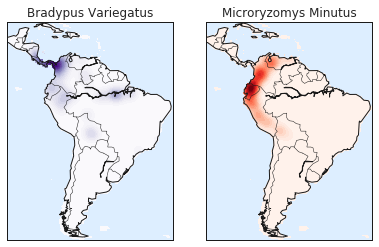

In [15]:
# 设置地图上的数据网格
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# 创建两个并排的图表
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # 使用basemap绘制海岸线和国境线
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # 构造分布的球面核密度估计
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # 仅计算陆地范围，-9999代表海洋
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # 绘制密度的轮廓
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

> Compared to the simple scatter plot we initially used, this visualization paints a much clearer picture of the geographical distribution of observations of these two species.

对比前面我们绘制的简单散点图，上面两个图表很清晰的展示了两种动物的地理位置分布情况。

## Example: Not-So-Naive Bayes

## 例子：不那么朴素的贝叶斯

> This example looks at Bayesian generative classification with KDE, and demonstrates how to use the Scikit-Learn architecture to create a custom estimator.

下面这个例子我们来看下使用KDE创建贝叶斯生成分类，并且展示如何使用Scikit-Learn创建自定义的评估器。

> In [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb), we took a look at naive Bayesian classification, in which we created a simple generative model for each class, and used these models to build a fast classifier.
For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class.
It's still Bayesian classification, but it's no longer naive.

在[深入：朴素贝叶斯分类](05.05-Naive-Bayes.ipynb)中，我们学习了朴素贝叶斯分类，里面构建了每个类别的简单生成模型并且使用这些模型来构建一个快速分类器。对于高斯朴素贝叶斯来说，生成模型就是简单的沿着坐标轴的高斯函数。使用密度估计算法如KDE，我们可以去除其中的“朴素”成分，然后对每个类别使用更加复杂的生成模型进行相同的分类工作。这仍然是贝叶斯分类，只是不再朴素。

> The general approach for generative classification is this:

>1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data.
   This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.   
3. From the number of examples of each class in the training set, compute the *class prior*, $P(y)$.
4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$.
   The class which maximizes this posterior is the label assigned to the point.

生成分类的通用方法如下：

1. 将训练数据依据标签划分成不同类别。
2. 对每个类别，使用KDE拟合数据获得一个生成模型。这允许你对于任何观察$x$和标签$y$计算出似然$P(x~|~y)$。
3. 对训练集中的每个类别，从样本数量计算得到*类别先验概率*$P(y)$。
4. 对一个未知点$x$，每个类别的后验概率是$P(y~|~x) \propto P(x~|~y)P(y)$。哪个类别具有最大的后验概率值，就将这个点设置为该类别标签。

> The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

上述算法很直观和易于理解；更困难的部分是将它实现在Scikit-Learn框架当中，这样就能使用网格搜索和交叉验证工具。

> This is the code that implements the algorithm within the Scikit-Learn framework; we will step through it following the code block:

下面是Scikit-Learn框架中实现这个算法的代码；我们过一遍这些代码片段：

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### The anatomy of a custom estimator

### 自定义评估器剖析

> Let's step through this code and discuss the essential features:

让我们一步一步的分析上面的代码并讨论其中最关键的特性：

```python
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
```

> Each estimator in Scikit-Learn is a class, and it is most convenient for this class to inherit from the ``BaseEstimator`` class as well as the appropriate mixin, which provides standard functionality.
For example, among other things, here the ``BaseEstimator`` contains the logic necessary to clone/copy an estimator for use in a cross-validation procedure, and ``ClassifierMixin`` defines a default ``score()`` method used by such routines.
We also provide a doc string, which will be captured by IPython's help functionality (see [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb)).

Scikit-Learn中的每个评估器都是一个类（译者注：Python类），对于评估器类来说最方便的就是继承`BaseEstimator`类以及相应的混合器，它们能提供标准的功能。例如这里`BaseEstimator`包含着代码逻辑当需要使用交叉验证过程时能复制评估器的副本，`ClassifierMixin`定义了默认的`score()`方法给分类器继承。下面是文档字符串，可以被IPython的帮助功能捕获到（参见[IPython的帮助和文档](01.01-Help-And-Documentation.ipynb)）。

> Next comes the class initialization method:

下面是类实例初始化方法：

```python
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

> This is the actual code that is executed when the object is instantiated with ``KDEClassifier()``.
In Scikit-Learn, it is important that *initialization contains no operations* other than assigning the passed values by name to ``self``.
This is due to the logic contained in ``BaseEstimator`` required for cloning and modifying estimators for cross-validation, grid search, and other functions.
Similarly, all arguments to ``__init__`` should be explicit: i.e. ``*args`` or ``**kwargs`` should be avoided, as they will not be correctly handled within cross-validation routines.

这个方法的代码是当对象实例通过`KDEClassifier()`创建完成后初始化执行的部分。在Scikit-Learn中，很重要的一点需要记住，初始化方法除了通过`self`设置对象属性外不能包括其他的操作。这是因为`BaseEstimator`中的代码逻辑在交叉验证、网格搜索和其他功能时需要克隆和修改评估器。类似的，`__init__`方法的参数应该是显示定义的：`*args`或`**kwargs`的定义方式应该避免，同样是因为它们无法被交叉验证过程正确的处理。

> Next comes the ``fit()`` method, where we handle training data:

接下来是`fit()`方法，这里进行数据拟合：

```python 
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

> Here we find the unique classes in the training data, train a ``KernelDensity`` model for each class, and compute the class priors based on the number of input samples.
Finally, ``fit()`` should always return ``self`` so that we can chain commands. For example:

首先找出训练数据中所有唯一的分类标签，对每个分类独立训练一个`KernelDensity`模型，然后根据输入样本数量计算每个分类的先验概率。最后`fit()`方法应该永远返回`self`令其支持链式操作。例如：

```python
label = model.fit(X, y).predict(X)
```

> Notice that each persistent result of the fit is stored with a trailing underscore (e.g., ``self.logpriors_``).
This is a convention used in Scikit-Learn so that you can quickly scan the members of an estimator (using IPython's tab completion) and see exactly which members are fit to training data.

注意一下`fit`得到的持久化结果应该保存在后缀下划线名称的属性当中（例如`self.logpriors_`）。这是Scikit-Learn的编码规范方便用户迅速的查看评估器的成员值（使用IPython的制表符补全）并获得已经拟合到训练数据上的成员变量值。

> Finally, we have the logic for predicting labels on new data:

最后我们看到的是在新数据上预测标签的逻辑：

```python
    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```

> Because this is a probabilistic classifier, we first implement ``predict_proba()`` which returns an array of class probabilities of shape ``[n_samples, n_classes]``.
Entry ``[i, j]`` of this array is the posterior probability that sample ``i`` is a member of class ``j``, computed by multiplying the likelihood by the class prior and normalizing.

因为这是一个概率分类器，我们首先实现了`predict_proba()`方法，它返回新数据在每个分类上的后验概率数组，形状是`[n_samples, n_classes]`。数组中的元素`[i, j]`是样本`i`属于分类`j`的后验概率值，通过将似然值与分类先验概率值相乘并标准化后得到。

> Finally, the ``predict()`` method uses these probabilities and simply returns the class with the largest probability.

最后`predict()`方法使用这些概率并在其中找到最大值，然后返回分类的标签。

### Using our custom estimator

### 使用我们的自定义评估器

> Let's try this custom estimator on a problem we have seen before: the classification of hand-written digits.
Here we will load the digits, and compute the cross-validation score for a range of candidate bandwidths using the ``GridSearchCV`` meta-estimator (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)):

让我们试一下这个自定义评估器，使用前面我们研究过的问题：手写数字分类。我们载入手写数字数据，然后针对一定范围的带宽值使用`GridSearchCV`元评估器计算交叉验证结果（参见[超参数和模型验证](05.03-Hyperparameters-and-Model-Validation.ipynb)）：

译者注：下面代码做了修改以适应新版本Scikit-Learn。包括GridSearchCV从属的包，参数cv和结果中使用cv_result_字典取分值。

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, cv=5)
grid.fit(digits.data, digits.target)

scores = grid.cv_results_['mean_test_score']

/home/wangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


> Next we can plot the cross-validation score as a function of bandwidth:

接下来我们可以绘制交叉验证分值与带宽之间的函数图像：

{'bandwidth': 4.641588833612779}
accuracy = 0.9677239844184753


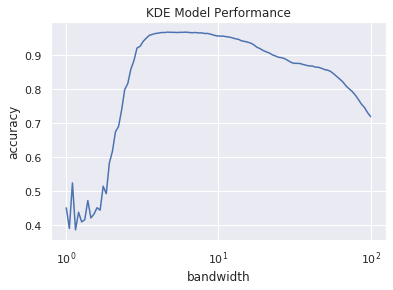

In [18]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

> We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96%; this is compared to around 80% for the naive Bayesian classification:

我们看到这个不那么朴素的贝叶斯分类器达到了交叉验证准确率超过96%；与朴素贝叶斯分类的大约80%比较：

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target, cv=5).mean()

0.8065207555552298

> One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a *full model* of the distribution of points we are comparing it to!
If desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure.

这样的生成分类器的一个优点是结果的可解释性：对于每个未知的样本，我们不但得到了概率分类，还获得了数据点分布情况的*完整模型*。如果需要的话，这可以提供一个样本具体分类的直观理由，而其他算法像SVM和随机森林通常是模糊的。

> If you would like to take this further, there are some improvements that could be made to our KDE classifier model:

> - we could allow the bandwidth in each class to vary independently
- we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e. use the scores from ``KernelDensity`` itself rather than the global prediction accuracy)

如果你希望更进一步，下面是我们KDE分类模型可以继续优化的一些建议：

- 我们可以允许每个分类使用独立的带宽值。
- 我们可以优化带宽值，不基于它们的预测分数，而是基于每个分类在生成模型下拟合训练数据的似然值（也就是使用`KernelDensity`本身的分数值来调整带宽，而不是全局的预测准确率）。

> Finally, if you want some practice building your own estimator, you might tackle building a similar Bayesian classifier using Gaussian Mixture Models instead of KDE.

最后，如果你希望练习构建你自己的评估器，你可以尝试一个相似的贝叶斯分类器，使用高斯混合模型而不是KDE。

<!--NAVIGATION-->
< [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) | [Contents](Index.ipynb) | [Application: A Face Detection Pipeline](05.14-Image-Features.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
